In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import sin, cos, sqrt, atan2

In [5]:
%matplotlib inline

In [6]:
df = pd.read_csv("../../api/bird_unofficial_api/csv_output.csv")

In [7]:
# Preprocessing and adding date columns
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
df['datetime'] = df['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
df['date_string'] = df['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['week_day'] = df['datetime'].apply(lambda x: days[x.weekday()])

In [8]:
df.head()

,id,latitude,longitude,battery_level,captive,time_stamp,datetime,date_string,week_day
0,9014ca4d-cafc-4834-b37b-cb8bafe6eea0,34.411820,-119.854743,90,False,1551395404,2019-02-28 15:10:04,2019-02-28,thu
1,8a8f7275-2193-48e6-bcee-365144d4bb00,34.413182,-119.857452,100,False,1551395404,2019-02-28 15:10:04,2019-02-28,thu
2,a31f4dd6-be2e-4f8f-97ac-55c157410406,34.413162,-119.857483,100,False,1551395404,2019-02-28 15:10:04,2019-02-28,thu
3,b7ed8cfd-c91a-471c-9e26-6da20b229654,34.410361,-119.857268,76,False,1551395404,2019-02-28 15:10:04,2019-02-28,thu
4,d727f677-2aaa-4a73-90b5-e00e533b8193,34.415275,-119.860435,98,False,1551395404,2019-02-28 15:10:04,2019-02-28,thu


In [33]:
df['date_string'].unique()

array(['2019-02-28', '2019-02-13', '2019-02-09', '2019-01-28',
       '2019-02-26', '2019-02-07', '2019-02-24', '2019-02-11',
       '2019-02-22', '2019-02-19', '2019-02-23', '2019-02-27',
       '2019-02-06', '2019-02-01', '2019-02-15', '2019-02-12',
       '2019-02-03', '2019-02-25', '2019-02-18', '2019-01-24',
       '2019-02-10', '2019-02-04', '2019-02-08', '2019-01-30',
       '2019-02-16', '2019-02-20', '2019-02-21', '2019-02-14',
       '2019-01-26', '2019-03-01', '2019-02-05', '2019-01-25',
       '2019-02-17', '2019-01-27', '2019-01-29', '2019-02-02',
       '2019-01-31'], dtype=object)

In [34]:
def get_count_for_date(ds):
    day_df = df[df['date_string'] == ds]
    freq_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['id'].nunique()
    freq_df.plot(figsize=(10,5))

In [35]:
# Group data by date
date_df = df.groupby('date_string')['id'].nunique()

In [36]:
# Group data by week day
week_day_df = df.groupby('week_day')['id'].nunique()
week_day_df = week_day_df.reindex(index = days) #To have the same order as we define in days

In [37]:
# Euclidean distance calculation (only roughly accurate for 10 min interval polling)
# start and end are tuples of (lat, long)
def distance(start, end):
    R = 6373.0
    dlon = end[1] - start[1]
    dlat = end[0] - start[0]
    a = (sin(dlat/2))**2 + cos(start[0]) * cos(end[0]) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance*1000 #km -> meters

In [38]:
# Return unique ids for given date
def day_ids(ds):
    day_df = df[df['date_string'] == ds]
    day_df = day_df.reset_index()
    unique_ids = pd.Series(day_df['id'].values).unique().tolist()
    print (pd.Series(day_df.id).nunique())
#     print (unique_ids)
    return unique_ids

In [39]:
# Returns df for specific Bird for a given day
def bird_data_by_day(ds, b_id):
    day_df = df[df['date_string'] == ds]
    day_df = day_df.reset_index()
    bird_df = day_df[day_df['id'] == b_id]
    return bird_df

In [40]:
def plot_bird_battery(ds, b_id):
    bird_df = bird_data_by_day(day, b_id)
    bird_df = bird_df.sort_values(by='datetime')
    bird_df = bird_df.reset_index(drop=True)
    bird_df.plot(x='datetime', y='battery_level', figsize=(10,5))

# Visualizations

40


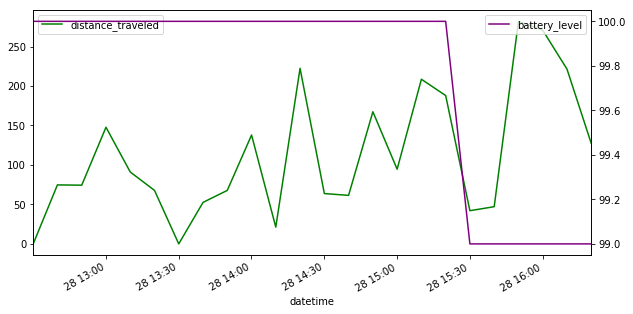

In [41]:
day = '2019-02-28'
unique_ids = day_ids(day)
bird_df = bird_data_by_day(day, unique_ids[1])
bird_df = bird_df.sort_values(by='datetime')
bird_df = bird_df.reset_index(drop=True)
bird_df['coordinates']= pd.Series(list(zip(bird_df.latitude, bird_df.longitude)))
dist_list = []
for i in range(len(bird_df.coordinates)):
    if i == 0:
        dist_list.append(0)
    else:
        dist_list.append(distance(bird_df.coordinates[i-1], bird_df.coordinates[i]))
bird_df['distance_traveled'] = pd.Series(dist_list)
# bird_df
ax = bird_df.plot(x='datetime', y=['distance_traveled'], figsize=(10,5), color = 'green')
ax1 = ax.twinx()

bird_df.plot(x='datetime', y='battery_level', ax = ax1, figsize=(10,5), color = 'purple')

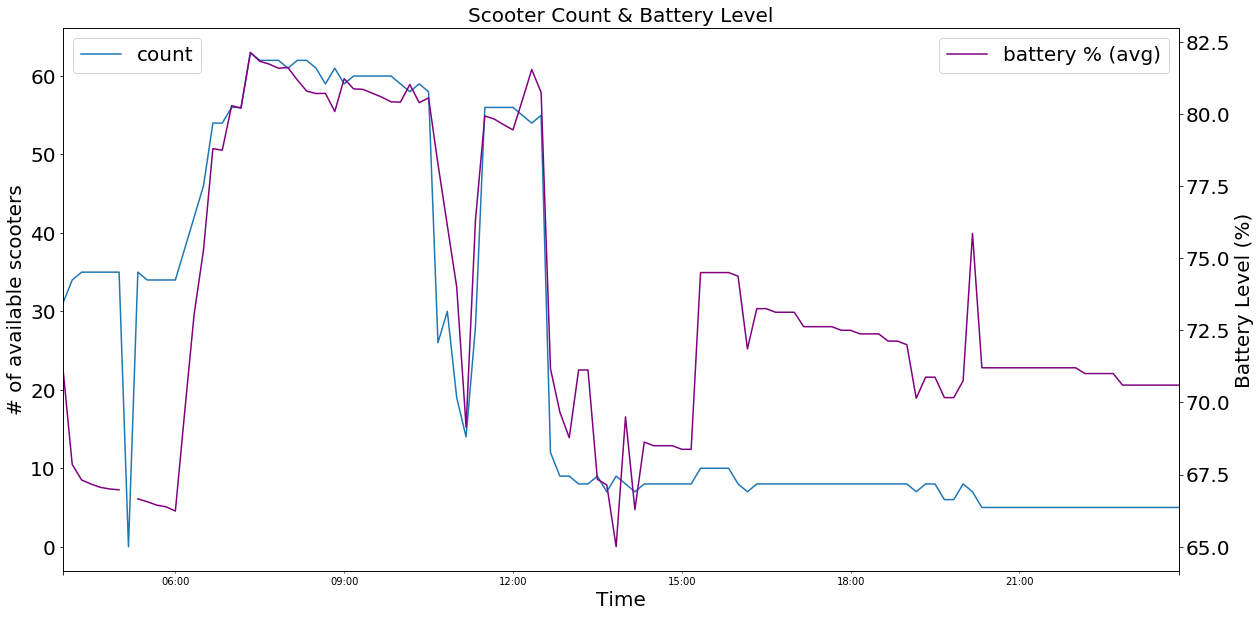

In [43]:
day_df = df[df['date_string'] == '2019-02-27']
fontsize = '20'
freq_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['id'].nunique()
ax = freq_df.plot(figsize=(20,10), label = 'count')
ax1 = ax.twinx()
ax.set_title("Scooter Count & Battery Level", fontsize = fontsize)
ax.set_xlabel("Time", fontsize = fontsize)
ax.legend(loc = 2, fontsize = fontsize)
ax.set_ylabel("# of available scooters", fontsize = fontsize)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax1.set_ylabel("Battery Level (%)", fontsize = fontsize)
ax1.tick_params(axis = 'both', labelsize = fontsize)
bat_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['battery_level'].mean()
bat_df.plot(figsize=(20,10), ax=ax1, color= 'purple', label = 'battery % (avg)')
ax1.legend(fontsize = fontsize)

In [45]:
bat_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['battery_level'].apply(mode)
bat_df.plot(figsize=(20,10), ax=ax1, color= 'purple')

NameError: name 'mode' is not defined

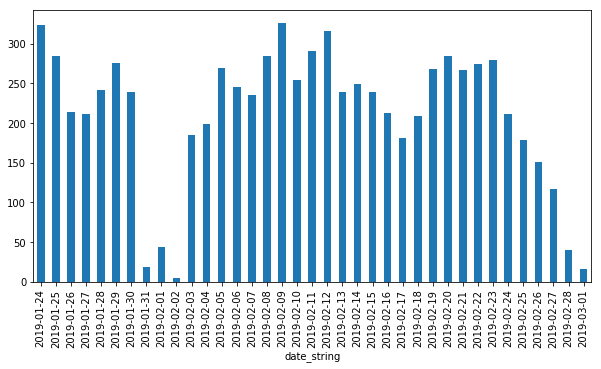

In [46]:
date_df.plot(kind='bar',figsize=(10,5))

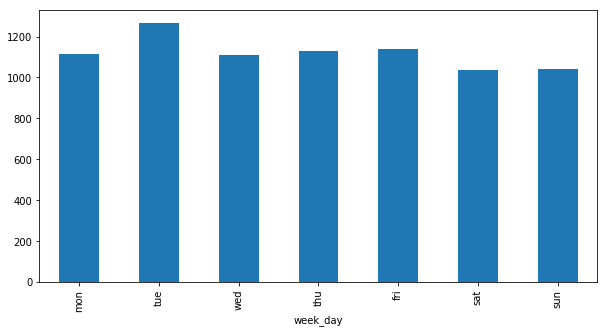

In [47]:
week_day_df.plot(kind='bar',figsize=(10,5))